In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from itertools import chain

In [2]:
vims_wave = np.loadtxt('vims_wave.txt')
new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
for number in new_array:
    new_string = 'df'+number+' = '+'pd.read_pickle("e_data/data'+number+'.pkl")'
    exec(new_string)

### Functions for different types of fits and curves (among other things)

In [3]:
def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2,.05])
    return my_fit[1]


In [4]:
df_list = []
for number in new_array:
    my_string = 'spec'+number+" = df"+number+"['spectrum']"
    exec(my_string)
    spec = 'spec'+number
    new_spec = locals()[spec]
    df_list.append(new_spec)

### Fitting All Spectra

In [5]:
#Define all fit spectra under one single list (specific year groups will be added later)
total_list = [] #total SPECTRUM list
mean_list = [] #List for shifts to be plotted later
for df in df_list:
    for spectrum in df:
        fit_thing = single_fit(spectrum)
        k = 0
        for number in fit_thing:
            if ((number >= .17) or (number <= -.03)):
                k += 1
        if k == 0:
            total_list.append(fit_thing)
            my_shift_value = shift_ret(fit_thing)
            mean_list.append(my_shift_value)

# Convert all lists objects within total_list to numpy arrays
total_array = np.asarray(total_list)
print(np.shape(total_array)) # Confirms that array is working correctly (should output 12655, 256), filtered is (11350,256) - 1305 spectra filtered out for averaging

(11350, 256)


In [6]:
unf_total = []
for df in df_list:
    for spectrum in df:
        fit_thing = single_fit(spectrum)
        unf_total.append(fit_thing)
unf_array = np.asarray(unf_total)
print(np.shape(unf_array)) # Should return (12655,256)

(12655, 256)


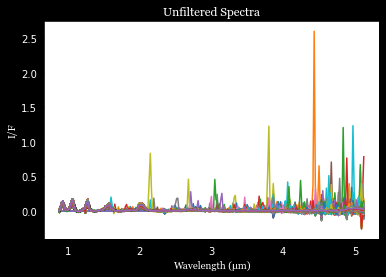

In [7]:
%matplotlib inline
plt.figure(facecolor='black')
for spectrum in unf_array:
    plt.plot(vims_wave,spectrum)
plt.title('Unfiltered Spectra',color='white',fontname='Georgia')
plt.xticks(color='white')
plt.yticks(color='white')
plt.xlabel('Wavelength (µm)',color='white',fontname='Georgia')
plt.ylabel('I/F',color='white',fontname='Georgia')
plt.show()

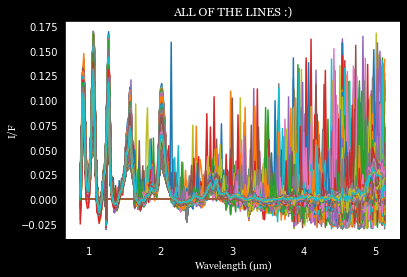

In [8]:
%matplotlib inline
plt.figure(facecolor='black') # Must go before plt.plot() statement to work properly
for spectrum in total_array:
    plt.plot(vims_wave,spectrum)
plt.title('ALL OF THE LINES :)',color='white',fontname='Georgia')
plt.xticks(color='white') #SETTING AXES TO WHITE - change these to black if you cannot read figure on repo or in standard notebook
plt.yticks(color='white')
plt.xlabel('Wavelength (µm)',color='white',fontname='Georgia')
plt.ylabel('I/F',color='white',fontname='Georgia')
plt.show()

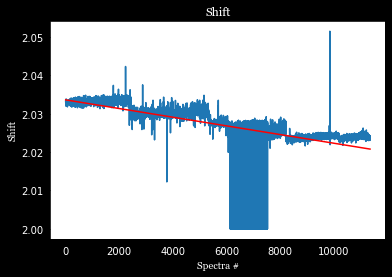

In [9]:
%matplotlib inline
plt.figure(facecolor='black')
length = len(mean_list)
x = np.linspace(0,length,length)
y = mean_list
p = np.polyval(np.polyfit(x,y,1),x)

plt.plot(x,y)
plt.plot(x,p,color='red')
plt.xticks(color='white')
plt.yticks(color='white')
plt.title('Shift',color='white',fontname='Georgia')
plt.xlabel('Spectra #',color='white',fontname='Georgia')
plt.ylabel('Shift',color='white',fontname='Georgia')
plt.show()

### Fitting separately by year groups

In [10]:
fit_groups = []
for (spec,number) in zip(df_list,new_array):
    exec('fit_list'+number+' = []')
    for spectrum in spec:
        fit_spec = single_fit(spectrum)
        k = 0
        for intensity in fit_spec:
            if ((intensity >= .17) or (intensity <= -.03)):
                k += 1
        if k == 0:
            locals()['fit_list'+number].append(fit_spec)
    exec('fit_array'+number+' = np.asarray(fit_list'+number+')')
    fit_groups.append(locals()['fit_array'+number])
#! Make it so you are only appending to numpy array and not to a list first

#Print shapes of groups --> ensures output is correct
total = 0
for (group,number) in zip(fit_groups,new_array):
    shape = str(np.shape(group))
    if len(shape) == 11:
        print('Data (20'+number[1:3]+' --> 20'+number[3:5]+') = '+shape[1:5]+' spectra, '+shape[-4:-1]+' channels')
        total += int(shape[1:5])
    elif len(shape) == 10:
        print('Data (20'+number[1:3]+' --> 20'+number[3:5]+') = '+shape[1:4]+' spectra, '+shape[-4:-1]+' channels')
        total += int(shape[1:4])

print('Total = '+str(total)) # Exports 11350 if run correctly

Data (2004 --> 2005) = 2414 spectra, 256 channels
Data (2006 --> 2007) = 2918 spectra, 256 channels
Data (2008 --> 2009) = 723 spectra, 256 channels
Data (2010 --> 2011) = 1473 spectra, 256 channels
Data (2012 --> 2013) = 688 spectra, 256 channels
Data (2014 --> 2015) = 1983 spectra, 256 channels
Data (2016 --> 2017) = 1151 spectra, 256 channels
Total = 11350


### Using arrays does not work for some reason --> why is this?

fit_array = np.array([])
for (spec,number) in zip(df_list,new_array):
    exec('fit_array'+number+' = np.array([])')
    for spectrum in spec:
        k = 0
        fit_spec = single_fit(spectrum) 
        for intensity in fit_spec:
            if ((intensity >= .17) or (intensity <= -.03)):
                k += 1
        if k == 0:
            exec('fit_array'+number+' = np.append(fit_array'+number+',fit_spec)')
    fit_array = np.append(fit_array,locals()['fit_array'+number])

#Print shapes of groups
for (group,number) in zip(fit_array,new_array):
    shape = str(np.shape(group))
    if len(shape) == 11:
        print('Data (20'+number[1:3]+' --> 20'+number[3:5]+') = '+shape[1:5]+' spectra, '+shape[-4:-1]+' channels')
    elif len(shape) == 10:
        print('Data (20'+number[1:3]+' --> 20'+number[3:5]+') = '+shape[1:4]+' spectra, '+shape[-4:-1]+' channels')
        

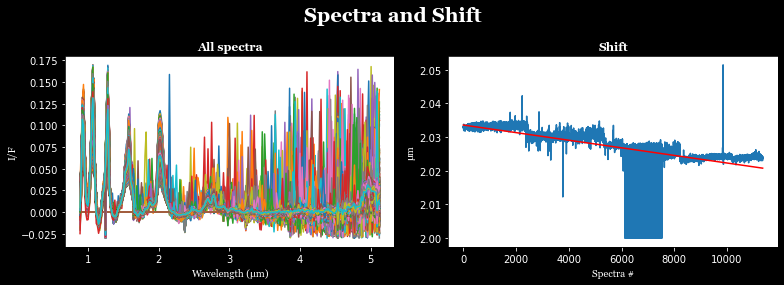

In [16]:
%matplotlib inline
fig,axs = plt.subplots(1,2,figsize=(11,4),facecolor='black')
fig.suptitle('Spectra and Shift',color='white',fontname='Georgia',fontweight='bold',fontsize=20)
for spectrum in total_array:
    axs[0].plot(vims_wave,spectrum)
axs[0].set_title('All spectra',color='white',fontname='Georgia',fontweight='bold')
axs[1].set_title('Shift',color='white',fontname='Georgia',fontweight='bold')
axs[0].set_xlabel('Wavelength (µm)',color='white',fontname='Georgia')
axs[0].set_ylabel('I/F',color='white',fontname='Georgia')
axs[1].set_xlabel('Spectra #',color='white',fontname='Georgia')
axs[1].set_ylabel('µm',color='white',fontname='Georgia')
x = np.linspace(0,length,length)
p = np.polyval(np.polyfit(x,mean_list,1),x)
axs[1].plot(x,mean_list)
axs[1].plot(x,p,color='red')
for ax in fig.get_axes():
    ax.tick_params(axis='x',colors='white')
    ax.tick_params(axis='y',colors='white')

fig.tight_layout()
plt.show()